In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%autosave 20

Autosaving every 20 seconds


# 부트스트랩

- 지난번에 한 구간추정은 이런 과정이였음.
    - 모집단으로부터 여러번 임의추출하여 여러개의 표본을 만들고
    - 각각의 표본으로부터 추정량의 값인 추정값를 계산하고
    - 계산된 추정값들로부터 추정량의 표준편차(또는 분산)을 구하고 + 중심극한정리(CLT)의 이론적 백업을 바탕으로
    - 모수 $\mu$에 대한 95% 신뢰구간을 제시
        1. $\mu$ 는 $\hat\theta \pm 2SD$인 구간에 95%확률로 속할 것이다.
        2. $\mu - \hat\theta$의 차이는 95%확률로 $2SD$보다 작을 것이다.

- 하지만 실전에서는 모집단에서 표본은 단 한번 추출함(시간과 비용)
- 그러면 여러개의 추정값들을 얻을 수 없기에 추정량의 표준편차($SD$)를 못 구하는데 어떻게 해야할까?
- 부트스트랩(bootstrap)을 통해 추정량의 표준편차를 구할 수 있음.

- 부트스트랩의 목적 : 하나의 샘플만 주어진 상황에서 추정량의 표준편차$SD$를 구하여 구간추정을 할 수 있도록 하자.
- 부트스트랩의 idea : 표본을 모집단처럼 이용하자!

그림

**(부트스트랩 과정)**
1. 표본으로부터 재추출(resampling)을 통해 재표본(resample)을 만든다.
2. (부트스트랩) 추정치를 구하고 기록한다.
3. 1.2를 여러번 반복한다.
4. 추정량의 분포를 근사하는 경험적 분포와 추정량의 표준편차 $SD$를 여러개의 추정치로부터 계산한다.!

**(유의해야 할 점)**
- 재추출(resampling)만 유의하면 된다.
    - 재추출은 표본으로부터 복원추출
    - 표본과 재표본의 크기는 같아야 함.


# Bootstrap 실습

## 모집단 생성

In [72]:
N = 100000  #모집단의 크기
theta = 0.5 #모비율 (지지율)

favor = int(N * theta) # 지지하는 유권자 수
opposite = N - favor
P = np.concatenate((np.ones(favor),np.zeros(opposite)))

## 모집단에서 하나의 확률표본만 있다고 가정

In [79]:
n = 1000
one_sample = np.random.choice(P,n,replace=False)

## 표본지지율은 ?

In [91]:
hat_theta = one_sample.mean()
hat_theta

0.507

## 부트스트랩 ㄱㄱㅆ

- 부트스트랩 과정 recap
    - 표본으로부터 복원추출하여 크기=n인 재표본을 생성
    - 생성된 재표본으로부터 추정량 계산
    - 이전 과정2개를 반복하여 여러개의 추정값들 계산
    - 추정값들의 분포가 추정량의 분포와 거의 비슷하다!
        - 추정량의 분산도 여기서 구하면 되겠지?

In [81]:
B = 1000 #부트스트랩 모의실험 횟수. 추정값들의 갯수와 동일

bootstrap_estimates = pd.DataFrame({"resample_estimate":np.zeros(B)}) # B개의 추정치를 저장할 데이터프레임 확보

for i in np.arange(B):
    resample = np.random.choice(one_sample,n,replace=True)
    bootstrap_estimates.loc[i,"resample_estimate"] = resample.mean()
bootstrap_estimates.head(10)

,resample_estimate
0,0.532
1,0.504
2,0.478
3,0.491
4,0.497
5,0.512
6,0.508
7,0.523
8,0.507
9,0.484


## 여러번 sampling vs 여러번 resampling(부트스트랩)

In [82]:
B = 1000

estimates = pd.DataFrame({"sample_rate" : np.zeros(B)})

for i in np.arange(B):
  sample = np.random.choice(P, n, replace=False)
  estimates.loc[i,'sample_rate'] = np.mean(sample)

estimates.head(10)

,sample_rate
0,0.501
1,0.488
2,0.503
3,0.486
4,0.478
5,0.484
6,0.498
7,0.499
8,0.496
9,0.516


<AxesSubplot:ylabel='Frequency'>

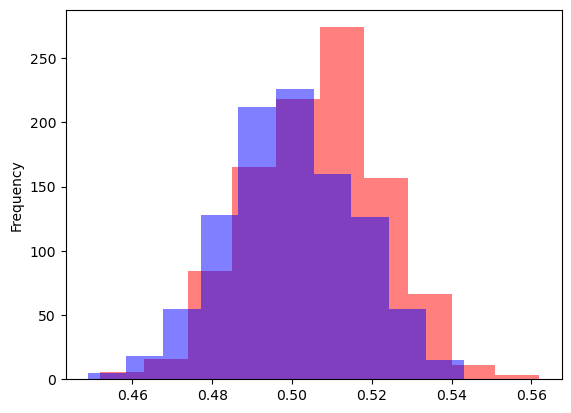

In [84]:
bootstrap_estimates.resample_estimate.plot.hist(alpha=0.5,color="red")
estimates.sample_rate.plot.hist(alpha=0.5,color="blue")

## $SD$구하기

- $SD$는 $Std(\hat\theta)$를 근사적으로 구한 값이라 하자.(이전에는 sampling을 여러번해서 구했었음)

In [85]:
SD = float(bootstrap_estimates.std())
round(SD,3)

0.016

참고 - 여러번 sampling한 추정량의 분포로부터 구한 SD는?

In [88]:
SD2 = float(estimates.std())
round(SD2,3)

0.016

- 매우매우 유사하다.

참고 - 중심극한 정리에 의한 이론적인 추정량의 분산은?

$$
\begin{aligned}
&Var(\hat\theta) = \frac{\sigma^2}{n} \\
&Std(\hat\theta) = \sqrt{\frac{\sigma^2}{n}} \\
\end{aligned}
$$

In [89]:
theta_hat_std = (P.var()/n)**(0.5)
theta_hat_std.round(3)

0.016

- 매우매우 유사하다.

# Bootstrap을 사용한 구간추정 

## SD활용

In [97]:
lower_bound = hat_theta - SD * 2
upper_bound = hat_theta + SD * 2
lower_bound,upper_bound

(0.4747162808443246, 0.5392837191556754)

## Percentile 사용

In [98]:
lower_bound = float(bootstrap_estimates.quantile(0.025))
upper_bound = float(bootstrap_estimates.quantile(0.975))
lower_bound,upper_bound

(0.475, 0.536025)

# 신뢰구간 해석

1. 95%의 확률로 신뢰구간이 모수를 포함한다. ($\hat\theta$가 확률변수, $\theta$는 고정된 상수,신뢰구간이 바뀐다. 고전적인 통계의 관점)
2. 95%의 확률로 모수가 신뢰구간에 포함된다. ($\theta$가 확률변수, $\hat\theta$는 고정된 상수,신뢰구간은 고정.베이지안 관점)


세부적으로 이렇게 적을 수 있지만 사실 차이가 이해하기 어려우므로 95% 신뢰구간에 모수가 포함되었을 가능성이 95%라 생각해도 큰 문제는 없다.

# 예제 : 중앙값의 신뢰구간 구하기

In [101]:
url1 = "https://ilovedata.github.io/teaching/bigdata2/data/seoul_bike_201909_3.csv"
bike = pd.read_csv(url1, encoding="CP949")

In [102]:
bike

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-17003,2019-09-28 16:10:55,368,SK 서린빌딩 앞,4,2019-09-28 17:03:32,2002,노들역 1번출구,14,52,8940.0
1,SPB-14405,2019-09-28 16:48:16,2024,상도역 1번출구,3,2019-09-28 17:03:44,2002,노들역 1번출구,18,15,1910.0
2,SPB-18431,2019-09-28 16:59:54,2002,노들역 1번출구,10,2019-09-28 17:03:57,2002,노들역 1번출구,10,2,30.0
3,SPB-04853,2019-09-28 15:31:49,207,여의나루역 1번출구 앞,32,2019-09-28 17:10:12,2002,노들역 1번출구,19,98,9610.0
4,SPB-11122,2019-09-28 15:35:41,207,여의나루역 1번출구 앞,14,2019-09-28 17:10:37,2002,노들역 1번출구,18,90,9450.0
...,...,...,...,...,...,...,...,...,...,...,...
407584,SPB-24072,2019-09-12 08:56:34,240,문래역 4번출구 앞,9,2019-09-12 09:03:37,99999,영남단말기정비,2,6,720.0
407585,SPB-16130,2019-09-18 10:13:09,99999,영남단말기정비,1,2019-09-18 11:38:30,99999,영남단말기정비,1,85,40.0
407586,SPB-03728,2019-09-25 08:00:28,2183,동방1교,7,2019-09-25 08:54:02,99999,영남단말기정비,5,53,12910.0
407587,SPB-08928,2019-09-30 07:49:27,2183,동방1교,10,2019-09-30 09:42:27,99999,영남단말기정비,7,2,0.0


In [104]:
bike2 = bike[["이용시간","이용거리"]]
bike2

,이용시간,이용거리
0,52,8940.0
1,15,1910.0
2,2,30.0
3,98,9610.0
4,90,9450.0
...,...,...
407584,6,720.0
407585,85,40.0
407586,53,12910.0
407587,2,0.0


In [127]:
bike2.describe()

,이용시간,이용거리
count,407589.000000,407589.000000
mean,30.156827,4253.336228
std,32.065934,5782.673901
min,1.000000,0.000000
25%,8.000000,1200.000000
50%,18.000000,2380.000000
75%,43.000000,5130.000000
max,2479.000000,153490.000000


In [105]:
n = 1000

one_sample = bike2.sample(n=n,replace=False,random_state = 13312)
one_sample.head(10)

,이용시간,이용거리
50771,25,1830.0
179510,20,3670.0
167844,8,1180.0
244482,3,210.0
102805,9,1330.0
330458,15,3090.0
91162,3,730.0
22447,6,1940.0
348599,16,1350.0
387639,15,2270.0


In [128]:
one_sample.describe()

,이용시간,이용거리
count,1000.000000,1000.000000
mean,28.150000,3923.110000
std,28.664598,4723.684348
min,1.000000,0.000000
25%,8.000000,1247.500000
50%,18.000000,2345.000000
75%,41.000000,5040.000000
max,321.000000,70890.000000


In [129]:
B = 1000
n = 1000

bootstrap_estimates = pd.DataFrame({"time_estimate":np.zeros(B),"distance_estimate":np.zeros(B)})
for i in np.arange(B):
    resample = one_sample.sample(n=n,replace=True,random_state = i)
    bootstrap_estimates.loc[i,"time_estimate"] = np.median(resample["이용시간"])
    bootstrap_estimates.loc[i,"distance_estimate"] = np.median(resample["이용거리"])
bootstrap_estimates.head(10)

,time_estimate,distance_estimate
0,18.0,2305.0
1,17.0,2330.0
2,18.0,2365.0
3,18.0,2410.0
4,19.0,2330.0
5,18.0,2355.0
6,17.0,2310.0
7,17.0,2320.0
8,17.0,2315.0
9,18.0,2375.0


In [120]:
lower_bound = float(np.quantile(bootstrap_estimates[["time_estimate"]],0.025))
upper_bound = float(np.quantile(bootstrap_estimates[["time_estimate"]],0.975))
lower_bound,upper_bound

(16.5, 20.0)

In [125]:
lower_bound = float(np.quantile(bootstrap_estimates["distance_estimate"],0.025))
upper_bound = float(np.quantile(bootstrap_estimates["distance_estimate"],0.975))
lower_bound,upper_bound

(2180.0, 2530.25)

In [133]:
bike2 = bike[ ["이용시간","이용거리"] ].rename(columns={"이용시간":"time", "이용거리":"distance"})

In [139]:
n = 1000 # 표본의 크기

one_sample = bike2.sample(n=n, replace=False, random_state=13312)
one_sample



B = 1000    # 붓스트랩 모의실험의 횟수

bootstrap_estimates = pd.DataFrame({'time_boot':np.zeros(B), 'distance_boot':np.zeros(B)})

for i in np.arange(B):
  boot_sample = one_sample.sample(n=n, replace=True, random_state=i)
  bootstrap_estimates.loc[i,'time_boot'] = np.median(boot_sample.time)
  bootstrap_estimates.loc[i,'distance_boot'] = np.median(boot_sample.distance) 

bootstrap_estimates 

,time_boot,distance_boot
0,18.0,2305.0
1,17.0,2330.0
2,18.0,2365.0
3,18.0,2410.0
4,19.0,2330.0
...,...,...
995,17.5,2305.0
996,19.0,2360.0
997,19.0,2315.0
998,17.0,2320.0


# 뭐야 왜 강의자료랑 다르게 나옴 ..?